In [1]:
# Set full width on jupyter notebook navigator
from IPython.core.display import HTML, display

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# For dark mode only, font in white
import matplotlib as mpl
"""
mpl.rcParams.update(
    {"axes.labelcolor": "white", "xtick.color": "white", "ytick.color": "white"}
)
"""

'\nmpl.rcParams.update(\n    {"axes.labelcolor": "white", "xtick.color": "white", "ytick.color": "white"}\n)\n'

# Analysis of the data

## Loading and selection of the Training set

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

In [4]:
dataset = pd.read_csv("./drinking_water_potability.csv")
dataset.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [5]:
train_set, test_set = train_test_split(
    dataset, train_size=0.75, random_state=42, stratify=dataset["Potability"]
)
print(train_set["Potability"].value_counts() / train_set.shape[0])
print(test_set["Potability"].value_counts() / test_set.shape[0])
del test_set

0    0.610094
1    0.389906
Name: Potability, dtype: float64
0    0.60928
1    0.39072
Name: Potability, dtype: float64


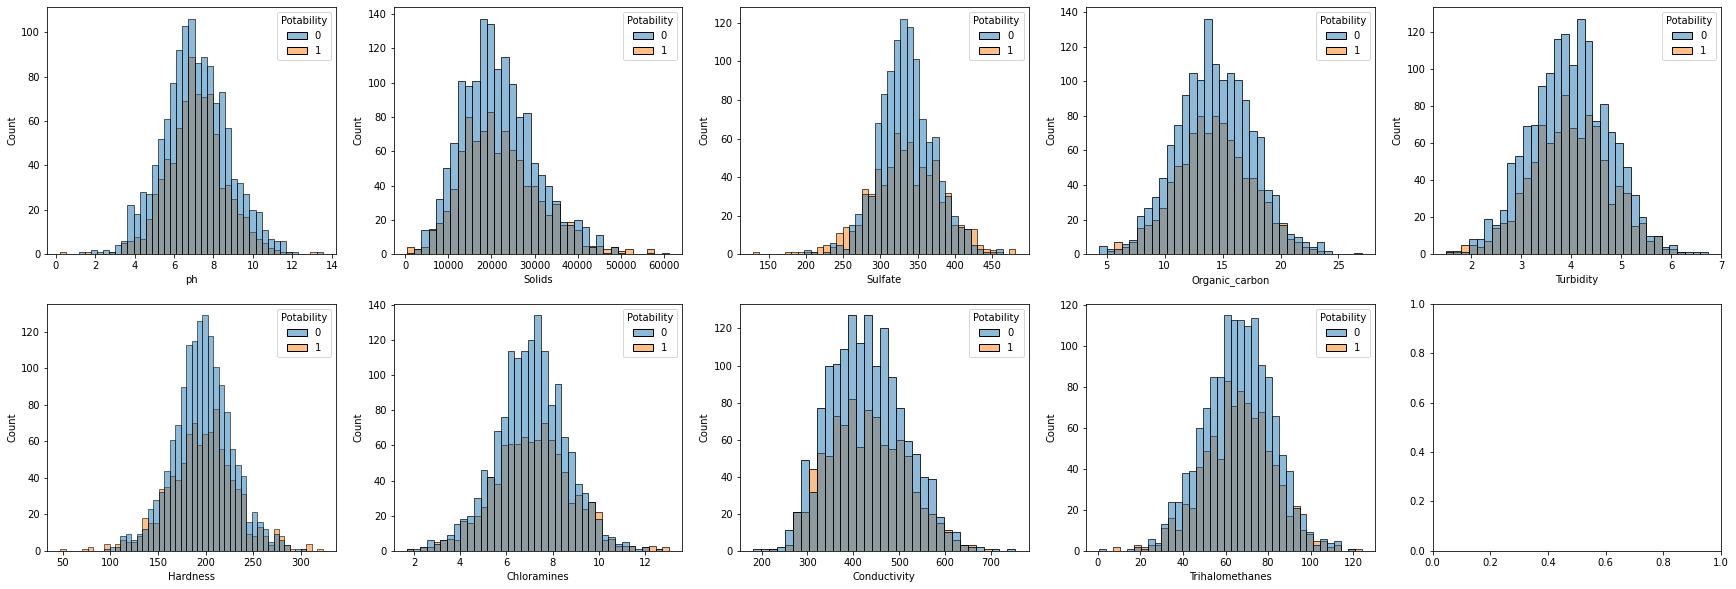

In [6]:
feature_cols = list(filter(lambda x: x != "Potability", train_set.columns))

fig, axes = plt.subplots(2, 5, figsize=(30, 10))

for i, col in enumerate(feature_cols):
    sns.histplot(data=train_set, x=col, ax=axes[i % 2, i // 2], hue="Potability")

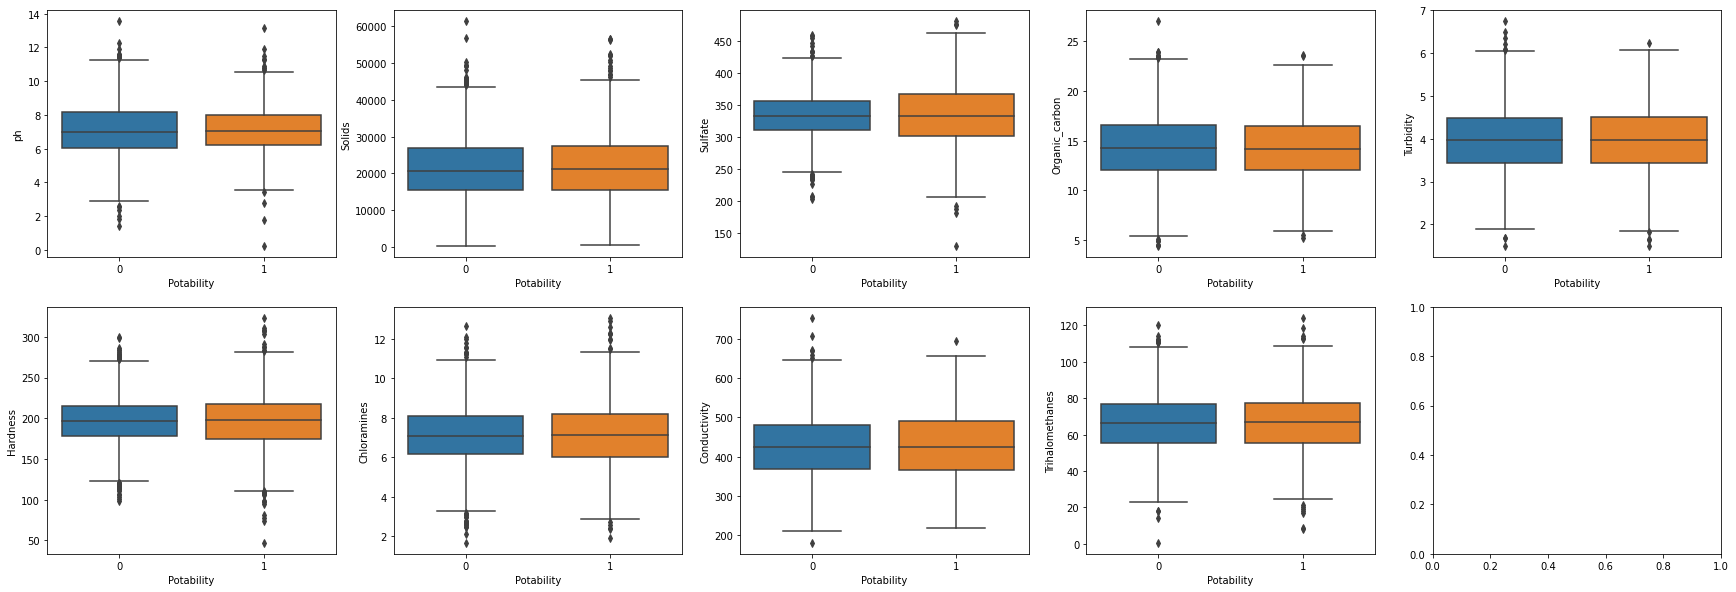

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(30, 10))

for i, col in enumerate(feature_cols):
    sns.boxplot(data=train_set, y=col, ax=axes[i % 2, i // 2], x="Potability")

<AxesSubplot:xlabel='ph'>

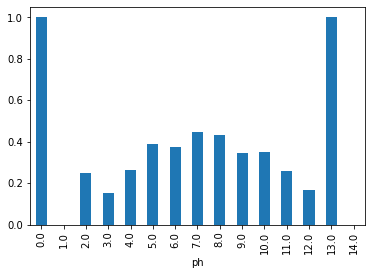

In [8]:
df = train_set.copy()
df["ph"] = df["ph"].round()
x = df.groupby(by="ph")["Potability"]
x = x.sum() / x.count()
del df
x.plot.bar()

In [9]:
# Decision: We remove waters with ph <= 1 or ph>=13 and Potability=1
# Because not really possible in real life
from utils import process_remove_outliers_ph

In [10]:
print(train_set.shape)
train_set = process_remove_outliers_ph(train_set)
print(train_set.shape)

(2457, 10)
(2455, 10)


## About the missing values

In [11]:
print("Pourcentages of missing values")
print(train_set.isna().sum(axis=0).sort_values(ascending=False))
(
    train_set.isna().sum(axis=0).sort_values(ascending=False) / train_set.shape[0] * 100
).round()

Pourcentages of missing values
Sulfate            591
ph                 366
Trihalomethanes    124
Hardness             0
Solids               0
Chloramines          0
Conductivity         0
Organic_carbon       0
Turbidity            0
Potability           0
dtype: int64


Sulfate            24.0
ph                 15.0
Trihalomethanes     5.0
Hardness            0.0
Solids              0.0
Chloramines         0.0
Conductivity        0.0
Organic_carbon      0.0
Turbidity           0.0
Potability          0.0
dtype: float64

In [12]:
from functools import reduce
from itertools import combinations

missing_columns = ["Sulfate", "ph", "Trihalomethanes"]
bools = {x: train_set[x].isna() for x in missing_columns}

counts = {}
options = []
for i in range(1, 4):
    for cols in combinations(missing_columns, i):
        options.append(cols)
        _ = reduce(
            lambda x, y: x & y,
            [bools[x] for x in cols]
            + [
                bools[x].apply(lambda y: y == False)
                for x in missing_columns
                if x not in cols
            ],
        )
        counts[" & ".join(cols)] = _.sum()
print("Number rows with those missing values")
pd.Series(counts).sort_values(ascending=False)

Number rows with those missing values


Sulfate                           481
ph                                270
Trihalomethanes                    80
Sulfate & ph                       77
Sulfate & Trihalomethanes          25
ph & Trihalomethanes               11
Sulfate & ph & Trihalomethanes      8
dtype: int64

### Observations

- Only a few rows with the 3 missing values
- Mostly sulfate missing, and mostly alone
- ph mostly missing alone too


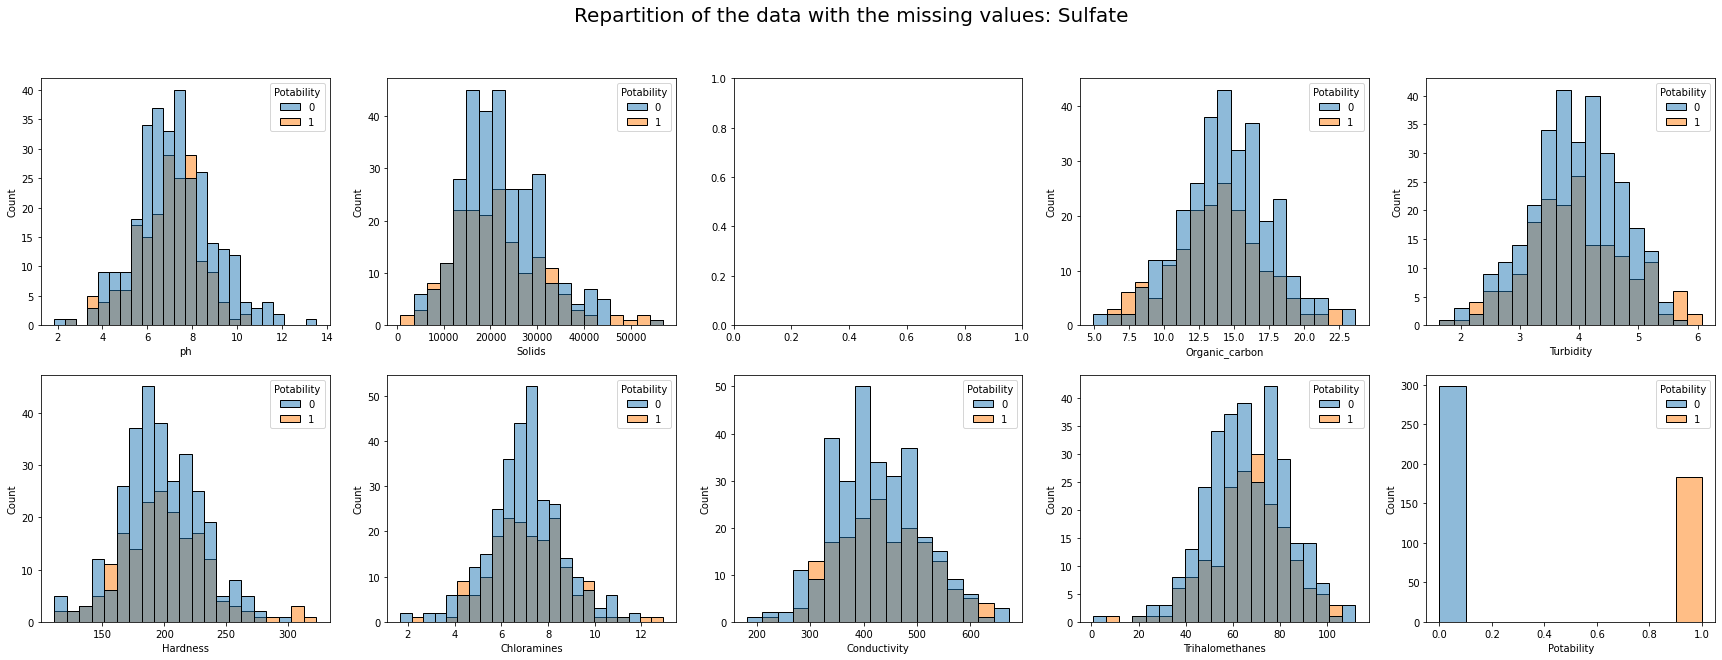

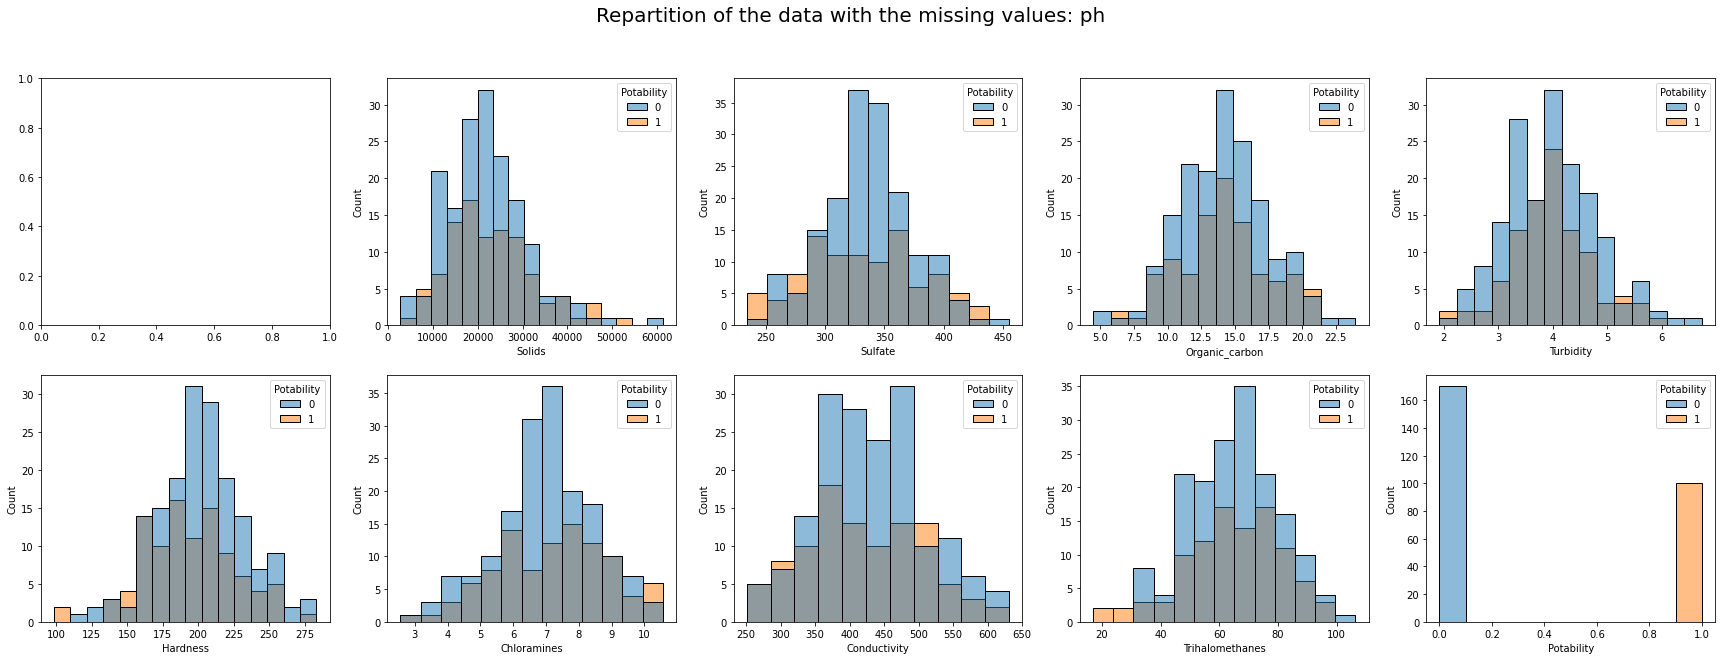

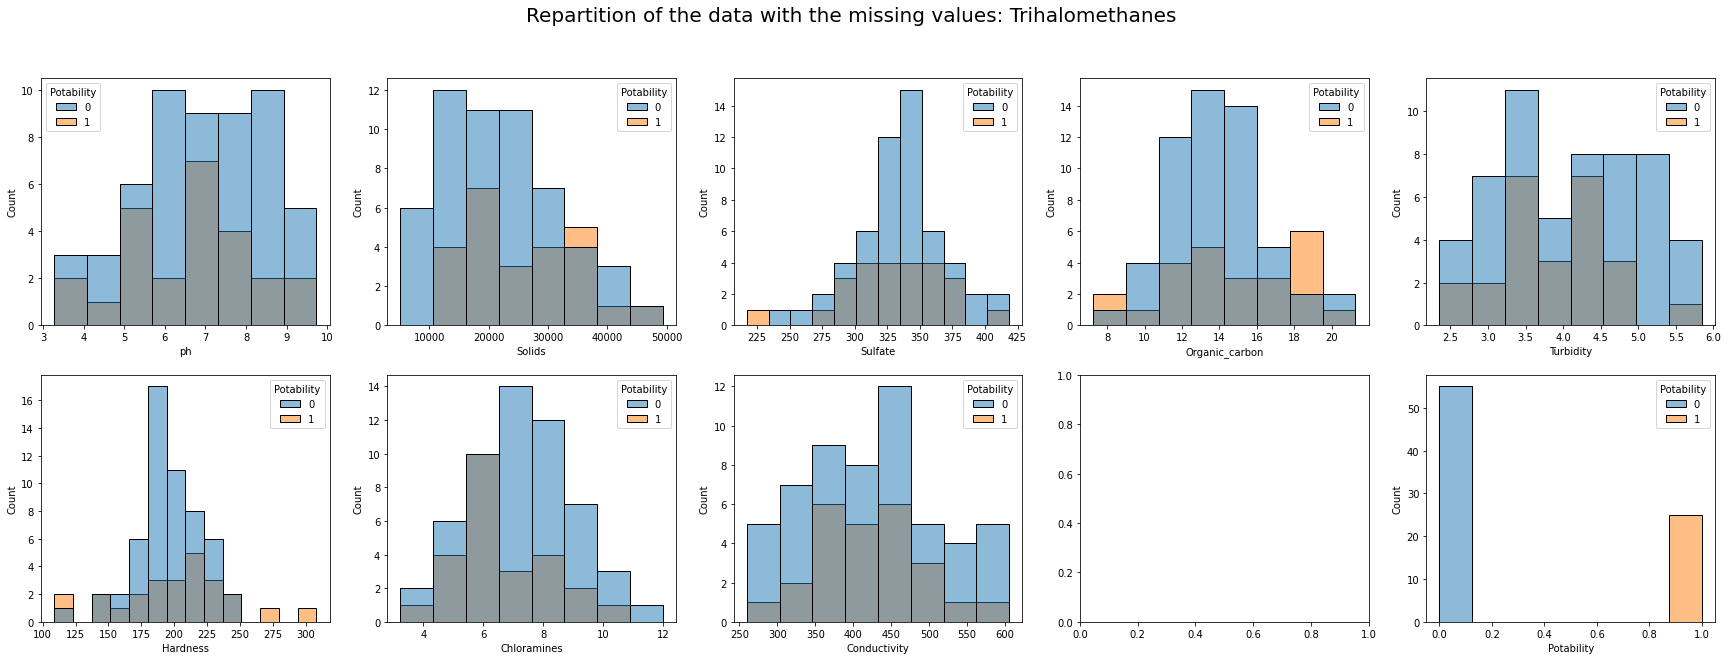

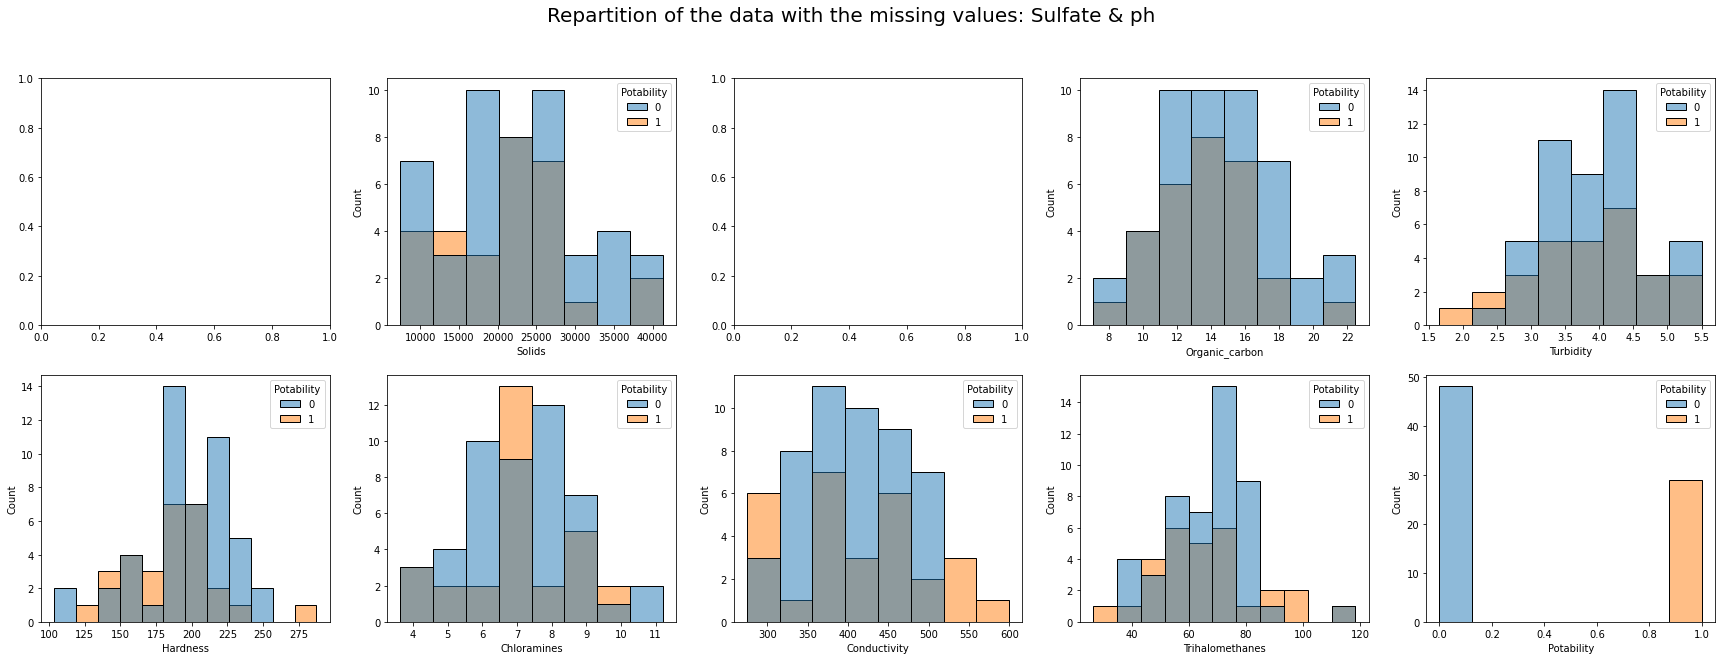

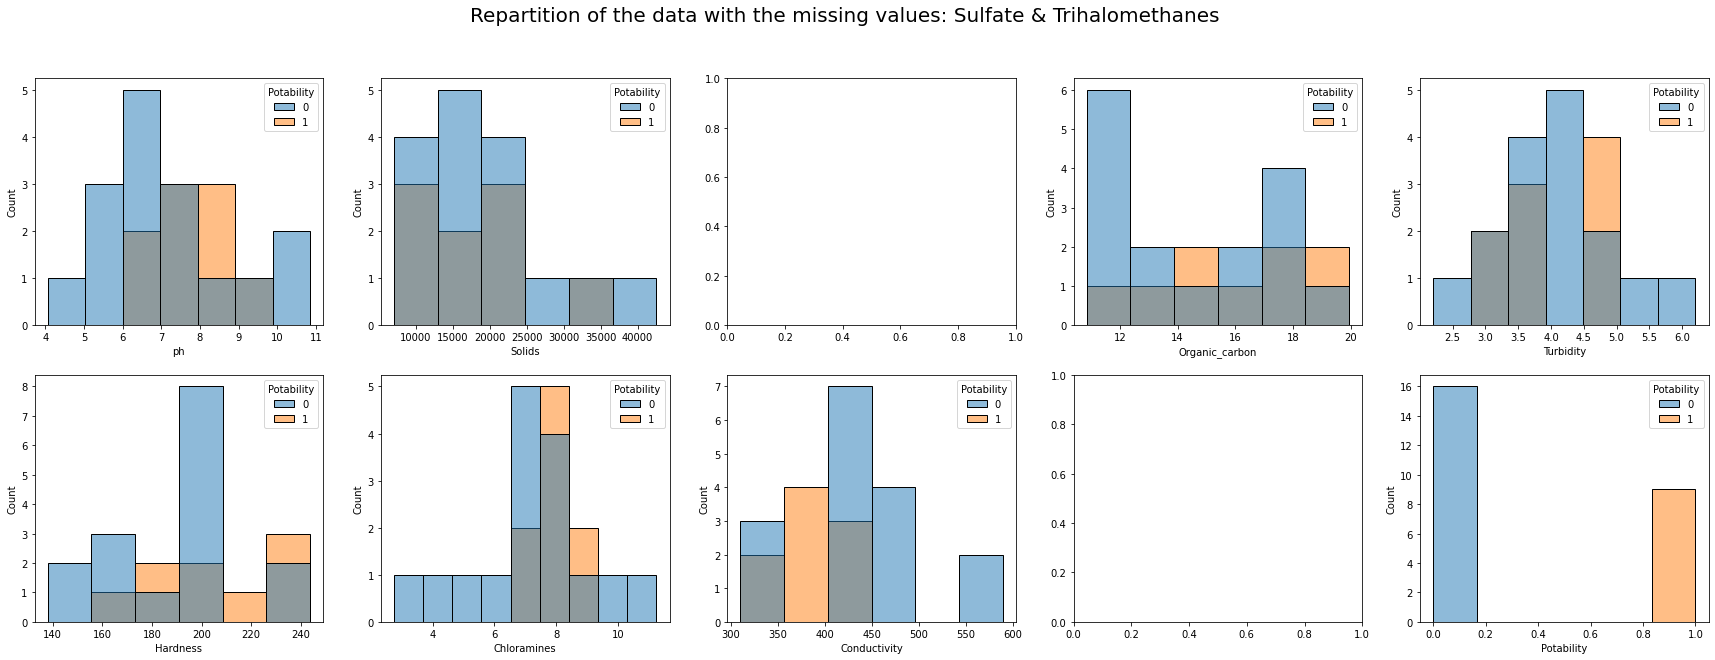

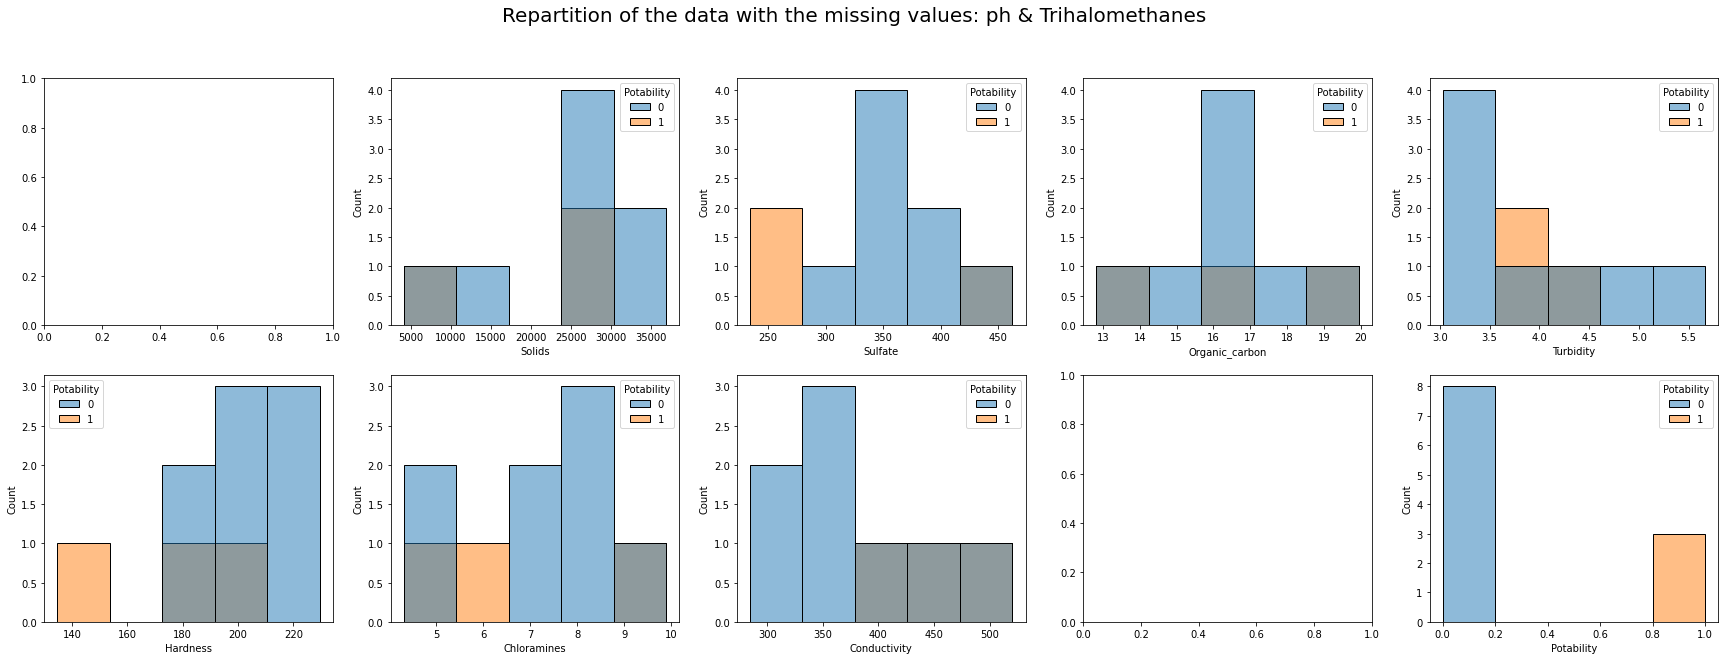

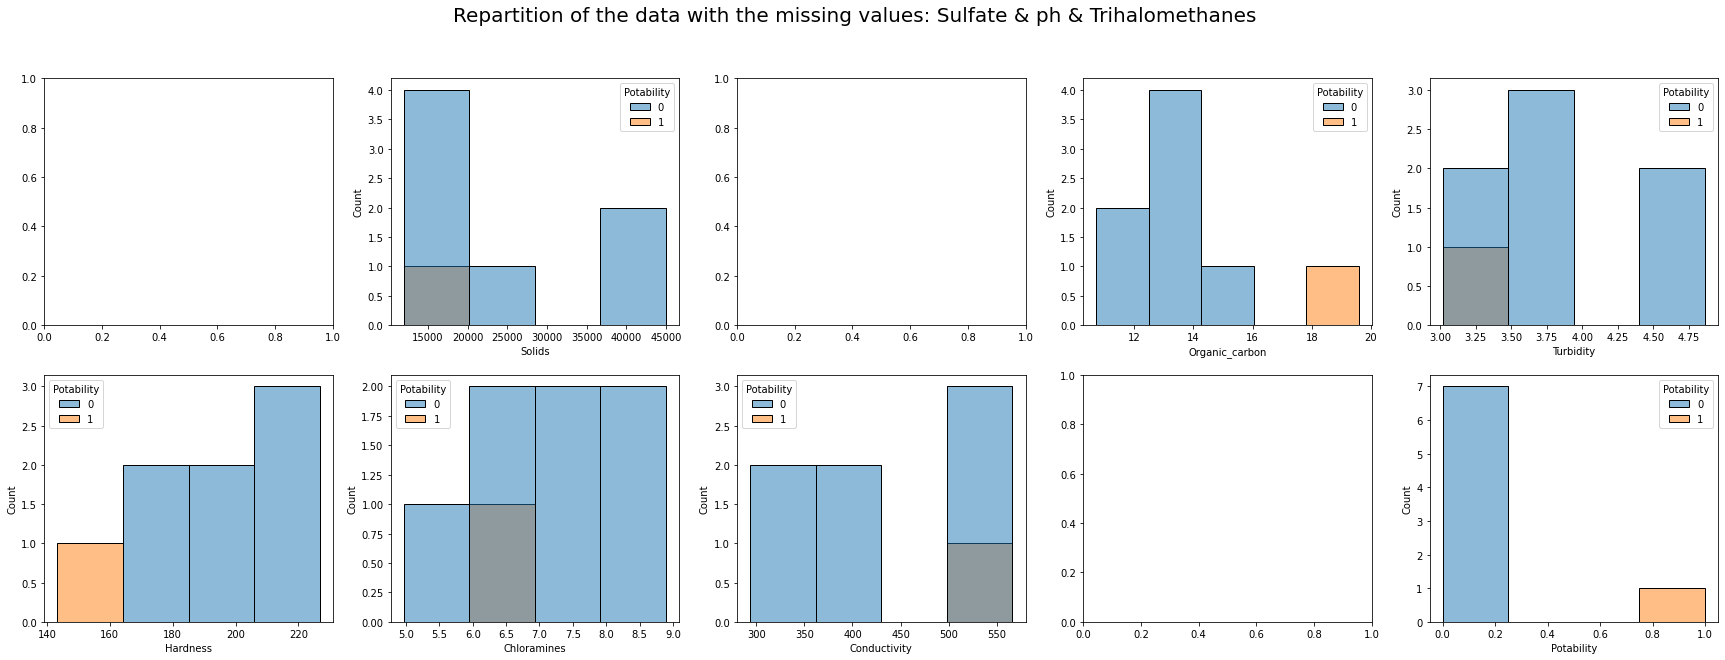

In [13]:
for option in options:
    sub_df = train_set[
        reduce(
            lambda x, y: x & y,
            [bools[x] for x in option]
            + [
                bools[x].apply(lambda y: y == False)
                for x in missing_columns
                if x not in option
            ],
        )
    ]

    fig, axes = plt.subplots(2, 5, figsize=(30, 10))
    plt.suptitle(
        f'Repartition of the data with the missing values: {" & ".join(option)}',
        fontsize=20,
    )
    for i, col in enumerate(sub_df.columns):
        sns.histplot(data=sub_df, x=col, ax=axes[i % 2, i // 2], hue="Potability")